## Short demonstration of how to perform Monte Carlo approximation of PI with Python 3.5

## I also show three different approaches (loop, vectorized and recursive) and try to find the quickest. In addition I want to see if it is possible to speed up the code even more using the @jit decorator, which you can get from the numba package

In [1]:
import numpy as np
import random
from numba import jit
import platform

In [2]:
platform.uname()

uname_result(system='Linux', node='gil-Inspiron-7559', release='4.4.0-21-generic', version='#37-Ubuntu SMP Mon Apr 18 18:33:37 UTC 2016', machine='x86_64', processor='x86_64')

In [3]:
def monteCarloPi(iterations):
    count = 0
    for i in range(iterations):
        x = random.uniform(0.,1.)
        y = random.uniform(0.,1.)
        dist = (x**2 + y**2)**.5
        if dist <= 1:
            count+=1
    return count/iterations * 4

In [4]:
monteCarloPi(1000000)

3.144272

In [5]:
@jit
def monteCarloPiJit(iterations):
    count = 0
    for i in range(iterations):
        x = random.uniform(0.,1.)
        y = random.uniform(0.,1.)
        dist = (x**2 + y**2)**.5
        if dist <= 1:
            count+=1
    return count/iterations * 4

In [6]:
def monteCarloPiNp(iterations):
    x = np.random.rand(iterations)
    y = np.random.rand(iterations)
    dist = (x**2 + y**2)**.5
    count = (dist <= 1).sum()
    return count/iterations * 4

In [7]:
@jit
def monteCarloPiNpJit(iterations):
    x = np.random.rand(iterations)
    y = np.random.rand(iterations)
    dist = (x**2 + y**2)**.5
    count = (dist <= 1).sum()
    return count/iterations * 4

### I wasn't able to use @jit with global variables, as it returns an error saying it is not implemented.. Not quite sure why this is the case, I will have to read more on JIT!

In [8]:
def monteCarloPiRecursive(iterations, first=True):
    if first:
        global count
        count = 0
        global iterations_total
        iterations_total = iterations
    if iterations == 0:
        return count/iterations_total*4
    else:
        x = random.uniform(0.,1.)
        y = random.uniform(0.,1.)
        dist = (x**2 + y**2)**.5
        if dist <= 1:
            count+=1
        return monteCarloPiRecursive(iterations-1,first=False)

### Loop

In [9]:
%%timeit -n 1000 -r 10
monteCarloPi(10000)

1000 loops, best of 10: 11.5 ms per loop


In [10]:
%%timeit -n 1000 -r 10
monteCarloPiJit(10000)

1000 loops, best of 10: 309 µs per loop


### Numpy

In [11]:
%%timeit -n 1000 -r 10
monteCarloPiNp(10000)

1000 loops, best of 10: 273 µs per loop


In [12]:
%%timeit -n 1000 -r 10
monteCarloPiNpJit(10000)

1000 loops, best of 10: 166 µs per loop


### Recursive

In [13]:
# need to increase the recursion limit  (default is 1000)
# this is just to have comparable tests and is definitely not recommended 
# also I put it at 15000 just as a (big) margin as I had error earlier when I would
# set the limit to something only slightly higher than the number of iterations/recursions
import sys
sys.setrecursionlimit(15000)

In [14]:
%%timeit -n 1000 -r 10
monteCarloPiRecursive(10000)

1000 loops, best of 10: 18.4 ms per loop


### Looks like in this case the recursive algorithm is slower than the loop and that the numpy implementation is the clear winner
### This also seems to be one of those occasions where using the @jit decorator improves the performance of code with numpy arrays, but even more interesting is how it improves the performance of the loop by almost two orders of magnitude!

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
pi_values = []
for x in np.logspace(0,8,num=100):
    pi_values.append(monteCarloPiNpJit(x))

In [17]:
import math

/home/gil/anaconda2/envs/Python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


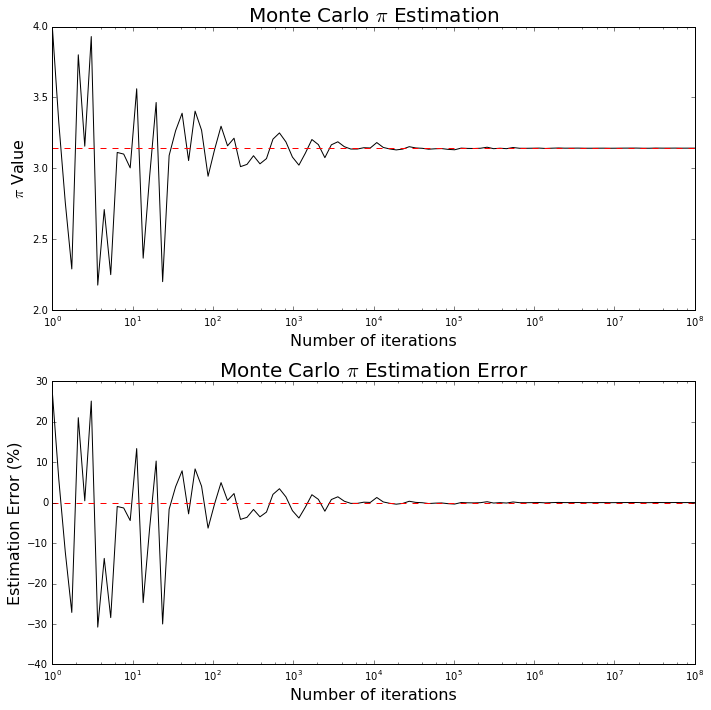

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Monte Carlo $\pi$ Estimation', size=20)
plt.semilogx(np.logspace(0,8,num=100),pi_values,c='k',label='Estimation')
plt.axhline(math.pi, linestyle='--',c='r',label='Math Package')
plt.xlabel('Number of iterations', size=16)
plt.ylabel('$\pi$ Value', size=16)
plt.subplot(212)
plt.title('Monte Carlo $\pi$ Estimation Error', size=20)
plt.semilogx(np.logspace(0,8,num=100),(np.array(pi_values)/math.pi - 1)*100,c='k')
plt.axhline(0,linestyle='--',c='r')
plt.xlabel('Number of iterations', size=16)
plt.ylabel('Estimation Error (%)', size=16)
plt.legend()
plt.tight_layout()
plt.show()

### Using the fastest code we can quickly then get an estimation of pi over number of iterations and we can see that after some 20000 iterations we should get a pretty reasonable result!

### Now let us just try a very naive parallelized implementation using the joblib library

In [35]:
import multiprocessing as mp
from joblib import Parallel, delayed

In [36]:
def monteCarloPiParallelNaive(iterations,verbose=12):
    # I hardcode the # cpus, because I did not manage to get an accurate cpu count using mp
    # this is because it counts logical cores too
    num_cores = 3
    if iterations < num_cores:
        return monteCarloPi(int(iterations))
    else:
        inputs = np.repeat(int(round(iterations/num_cores)), num_cores)
        results = Parallel(n_jobs=num_cores, verbose=verbose)(delayed(monteCarloPi)(i) for i in inputs)
        return sum(results)/len(results)

In [38]:
import time 

In [39]:
time_test = []
for x in np.logspace(0,8,num=100):
    start=time.time()
    monteCarloPiParallelNaive(x,verbose=0)
    time_test.append(time.time() - start)

In [40]:
time_test_2 = []
for x in np.logspace(0,8,num=100):
    start=time.time()
    monteCarloPi(int(x))
    time_test_2.append(time.time() - start)

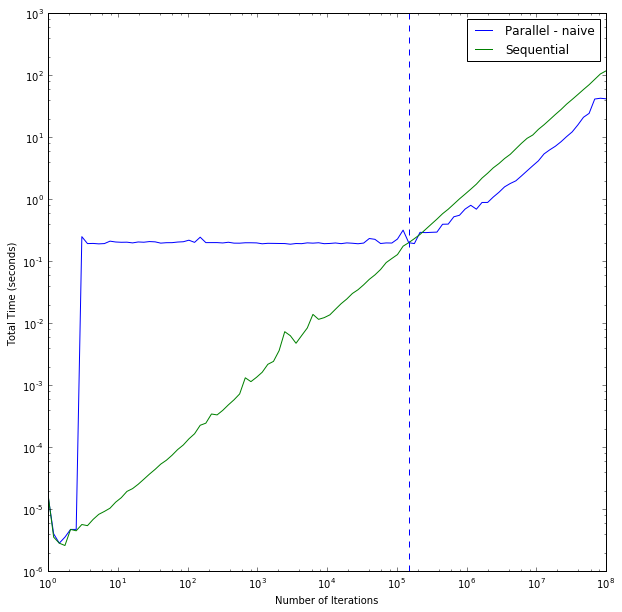

In [43]:
plt.figure(figsize=(10,10))
plt.loglog(np.logspace(0,8,num=100),np.array(time_test),label='Parallel - naive')
plt.loglog(np.logspace(0,8,num=100),np.array(time_test_2),label='Sequential')
plt.xlabel('Number of Iterations')
plt.ylabel('Total Time (seconds)')
plt.axvline(1.5e5,linestyle='--')
plt.legend(loc='best')
plt.show()

### After 20,000 iterations the time lost in syncronizing and waiting for the slower calculations is 'worthwhile' and parallel calculation becomes more efficient. Ideally, to run these tests I would decrease the priority (set the niceness) of all the tasks on my machine and prioritise python.

In [37]:
def monteCarloPiParallel(iterations,verbose=12):
    if iterations < 2e5:
        return monteCarloPi(int(iterations))
    #switch to parallel for >20,000 iterations
    else:
        num_cores = 3
        inputs = np.repeat(int(round(iterations/num_cores)), num_cores)
        results = Parallel(n_jobs=num_cores, verbose=verbose)(delayed(monteCarloPi)(i) for i in inputs)
        return sum(results)/len(results)

In [45]:
time_test_3 = []
for x in np.logspace(0,8,num=100):
    start=time.time()
    monteCarloPiParallel(int(x),verbose=0)
    time_test_3.append(time.time() - start)

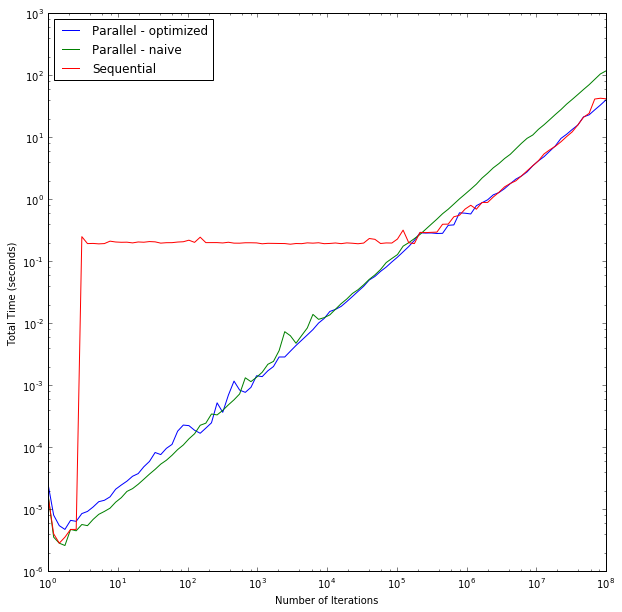

In [46]:
plt.figure(figsize=(10,10))
plt.loglog(np.logspace(0,8,num=100),np.array(time_test_3),label='Parallel - optimized')
plt.loglog(np.logspace(0,8,num=100),np.array(time_test_2),label='Parallel - naive')
plt.loglog(np.logspace(0,8,num=100),np.array(time_test),label='Sequential')
plt.xlabel('Number of Iterations')
plt.ylabel('Total Time (seconds)')
plt.legend(loc='best')
plt.show()

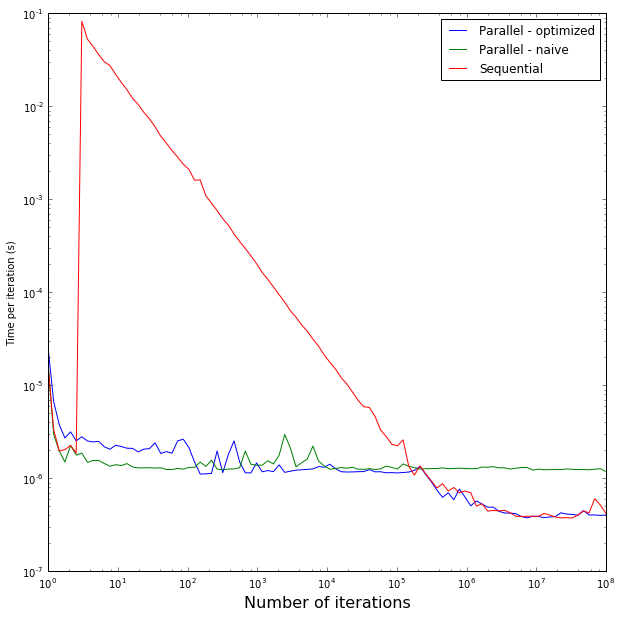

In [48]:
plt.figure(figsize=(10,10))
plt.loglog(np.logspace(0,8,num=100),np.divide(np.array(time_test_3),np.logspace(0,8,num=100)),label='Parallel - optimized')
plt.loglog(np.logspace(0,8,num=100),np.divide(np.array(time_test_2),np.logspace(0,8,num=100)),label='Parallel - naive')
plt.loglog(np.logspace(0,8,num=100),np.divide(np.array(time_test),np.logspace(0,8,num=100)),label='Sequential')
plt.xlabel('Number of iterations',size=16)
plt.ylabel('Time per iteration (s)')
plt.legend()
plt.show()

### Conclusion: Parallel programming is only worthwhile for some computations and should be used carefully! Obviously this is not necessarily the most optimal way to parallelize this particular code and greater speeds can be achieved using Numpy arrays and JIT, this was just to practice Parallel Python :) 